Created: 29-04-2022, Last Updated: 12-05-2022
# Problem Set 1 (Dynamic Programming)
## Student: Philine Meyjohann
The goal of this homework is to gain some experience with standard dynamic programming methods for solving Markov decision processes with known transition and reward functions. The MDP to study is a simple controlled queueing system where the goal is to control the number of requests waiting in a queue. Requests are generated in a stationary stochastic fashion and are being served at a rate controlled by the learning agent. This can
be formulated as aMarkov decision process as follows:
+ **The state space** consists of the integers $0, 1, 2, ..., N-1$, with $N=100$, corresponding to the length of the queue.
+ **The action space** consists of two actions: action $a_{low}$ corresponding to a low service rate
of $q(a_{low})= q_{low} = 0.51$ and action $a_{high}$ corresponding to a high service rate of $q(a_{high}) = q_{high} = 0.6$.
+ **The reward function** assigns a reward of $r(x,a) = -(x/N)^2-c(a)$, with $c(a)$ being the cost of action $a$. This cost is defined for the two actions as $c(a_{low}) = 0$ and $c(a_{high}) = 0.01$.
+ **The transition function** describes the dynamics of the queue as follows. The arrival rate $p = 0.5$ models the rate at which new requests arrive into the queue and the controlled service rate models the rate at which requests leave the queue. In each round, the queue length increases by 1 with probability p and decreases by 1 with probability $q(a)$ corresponding to the action $a$ taken. Precisely, letting $x_t$ be the current queue length, $a_t$ be the action taken by the agent, we define $I_t \in \{0,1\}$ as the increment such that $P[I_t = 1] = p$ and $S_t \in \{0,1\}$ as the decrement such that $P[S_t = 1] = q(a_t)$, the queue length is updated in each round as $$x_{t+1} = trunc(x_t + I_t - S_t),$$ where the “trunc” operator truncates the value to the interval $[0,N-1]: trunc(x) = \min \{N-1, \max\{x,0\}\}$.
+ **The discount factor** will be set as $\gamma = 0.9$.

## Preliminaries

In [1]:
# import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# define basic properties
N = 100
X = N # state space
A = 2 # action space
p = 0.5 # arrival rate
gamma = 0.9 # discount factor

# action space
q_low = 0.51
q_high = 0.6
q = [q_low, q_high]

# costs
c_low = 0
c_high = 0.01
c = [c_low, c_high]

## Problem 1: Policy evaluation
The first problem is to study the performance of the following simple policies:
+ **Lazy policy:** the policy that always uses the low service rate: $\pi_{lazy}(x) = a_{low}$.
+ **Aggressive policy:** the policy that uses the low service rate for short queues ($\pi_{aggr}(x) = a_{low}$ for $x < 50$) and the high service rate for long queues ($\pi_{aggr}(x) = a_{high}$ for $x \geq 50$).

Calculate the value functions of these policies using one of the following methods:
+ The power iteration method covered in class. This method is described in detail in Section 4.1 of Sutton & Barto (2018) under the name “iterative policy evaluation”.
+ Directly solving the Bellman equations through the identity $V^\pi = (I-\gamma P^\pi)^{-1}r^\pi$, where $r^\pi$ is the N-dimensional vector with its xth entry given as $r^\pi(x)=r(x,\pi(x))$ and $P^\pi$ is the NxN-dimensional matrix with entries $P^\pi(x,x')=P(x'|x,\pi(x))$. This identity follows from observing that the Bellman equations for policy evaluation can be written as the linear system of equations $V^\pi = r^\pi+\gamma P^\pi V^\pi$; reordering gives the result.

Having evaluated the policies, plot the difference between the resulting value functions, $V^{\pi_{lazy}}-V^{\pi_{aggr}}$. Which policy is better in state 50? What about state 80?

### Define the environment and relevant functions

In [3]:
# define possible states
states = np.linspace(0,N-1,N).astype('int')
states

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [4]:
# define reward
reward = np.zeros((X, A))
for a in range(A):
    for x in range(X):
        reward[x,a] = -(x/N)**2 - c[a]

In [5]:
# constructs a transition model P for queue environment with size (N,N)
# P[x,y,a] gives the probability of moving from state x to state y when taking action a
def move(x,delta_x,N): # 
    new_x = x + delta_x
    return np.maximum(np.minimum(new_x,N-1),0)

def queue_env(N): # constructs X by X transition matrix for policy pi
    
    P = np.zeros((N, N, A)) 
    
    for x in range(0,N):
        for y in range(0,N):
            for a in range(0,A):
                if y == move(x,0,N):
                    if x == 0:
                        P[x,y,a] = 1 - ((1-q[a])*p)
                    elif x == N-1:
                        P[x,y,a] = 1 - (q[a]*(1-p))
                    else:
                        P[x,y,a] = (1-q[a])*(1-p) + q[a]*p
                elif y == move(x,1,N):
                    P[x,y,a] = (1-q[a])*p
                elif y == move(x,-1,N):
                    P[x,y,a] = q[a]*(1-p)
    return P

In [6]:
P = queue_env(N)
P[:,:,1]

array([[0.8, 0.2, 0. , ..., 0. , 0. , 0. ],
       [0.3, 0.5, 0.2, ..., 0. , 0. , 0. ],
       [0. , 0.3, 0.5, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0.2, 0. ],
       [0. , 0. , 0. , ..., 0.3, 0.5, 0.2],
       [0. , 0. , 0. , ..., 0. , 0.3, 0.7]])

In [7]:
# transition matrix for policy pi
def transition(P,pi):
    X = np.size(P,0)
    P_pi = np.zeros((X,X))
    for x in range(X):
        for y in range(X):
            P_pi[x,y]=P[x,y,0]*pi[x,0] + P[x,y,1]*pi[x,1]
    return P_pi

In [8]:
# policy evaluation subroutine
# inverting the matrix (I - gamma P_pi)
def evaluate(P,pi,r,gamma):
    X = np.size(P,0)
    value = np.zeros((X))
    
    r = r[:,0]*pi[:,0] + r[:,1]*pi[:,1]

    P_pi = transition(P,pi)
    I = np.eye(X)
    value = np.linalg.inv(I-gamma*P_pi).dot(r)

    return value

### Define the policies

In [9]:
# define the policies
# policy maps (x,a) pair to probability of taking action a in state x

# lazy policy
pi_lazy = np.zeros((X,A))
for x in range(0,X):
    pi_lazy[x,0] = 1

# aggressive policy
pi_aggr = np.zeros((X,A))
for x in range(0,X):
    if x < 50:
        pi_aggr[x,0] = 1
    else:
        pi_aggr[x,1] = 1

### Evaluate the policies

In [10]:
# evaluate lazy policy
value_lazy = evaluate(P, pi_lazy, reward, gamma)

In [11]:
# evaluate aggressive policy
value_aggr = evaluate(P, pi_aggr, reward, gamma)

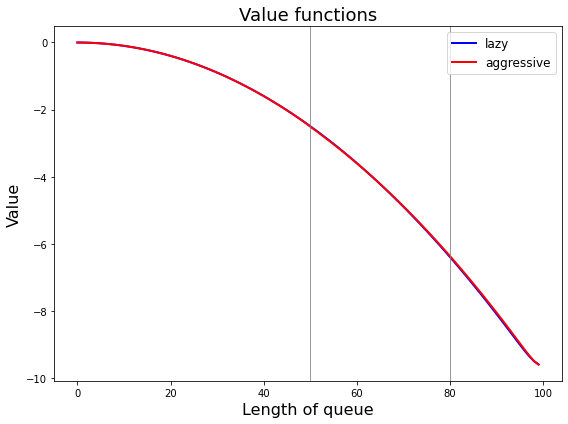

In [12]:
# plotting the value functions
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True

plt.title("Value functions", fontsize=18)
plt.plot(states, value_lazy, color="blue", label="lazy", linewidth=2)
plt.plot(states, value_aggr, color="red", label="aggressive", linewidth=2)
plt.axvline(x=50, color="gray", linewidth=0.8)
plt.axvline(x=80, color="gray", linewidth=0.8)
plt.legend(loc="upper right", fontsize=12)
plt.xlabel('Length of queue', fontsize=16)
plt.ylabel('Value', fontsize=16)

plt.show()

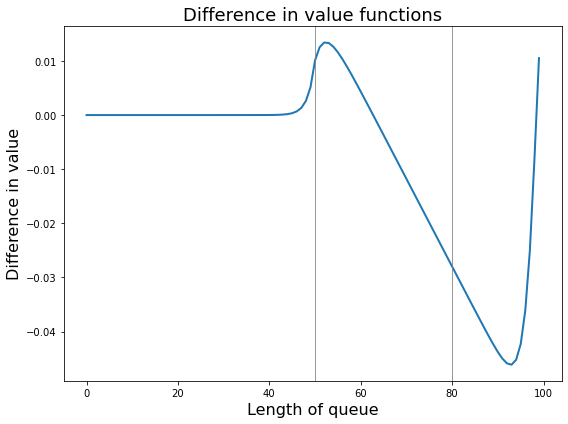

In [13]:
# plotting the difference in value functions
diff_value = value_lazy - value_aggr

plt.title("Difference in value functions", fontsize=18)
plt.plot(states, diff_value, linewidth=2)
plt.axvline(x=50, color="gray", linewidth=0.8)
plt.axvline(x=80, color="gray", linewidth=0.8)
plt.xlabel('Length of queue', fontsize=16)
plt.ylabel('Difference in value', fontsize=16)

plt.show()

In [14]:
print("Difference in value functions:")
print("State 50: ", diff_value[50])
print("State 80: ", diff_value[80])

Difference in value functions:
State 50:  0.010109901063740878
State 80:  -0.027995658268295642


### Answer

***Which policy is better in state 50? What about state 80?***

The lazy policy is better in state 50. This seems intuitive given that the lazy policy incurs no costs when servicing the queue and the slower service rate only has a marginal impact at a time when the queue is still quite short. For the aggressive policy, the higher cost outweighs the higher service rate in this state. However, this relationship reverses in state 80, when the queue length is longer. Now the aggressive policy outperforms the lazy policy given that the higher cost is of less importance at a time when it is imperative to decrease the queue length. This is captured by the first term in the reward function.

## Problem 2: Value Iteration and Policy Iteration
The second problem is to calculate the optimal policy using the two elementary dynamic programming methods covered in class: Policy Iteration and Value Iteration. Plot the value functions produced by the two methods after 10, 20, 50, and 100 iterations! Which method converges faster to the optimal value function in terms of the number of iterations? What are the respective runtimes of performing 100 iterations with the two methods? What is your interpretation of these results?

Based on the results above, plot the difference between the optimal value function and the value functions of the two policies evaluated in Problem 1, $V^* - V^{\pi_{lazy}}$ and $V^*-V^{\pi_{aggr}}$!

Can you verify that $V^*$ strictly improves over these value functions? What is the optimal policy and how is it different from the basic ones evaluated in the first problem?

## Hints
+ For policy iteration, use the policy evaluation method developed in Problem 1 as a subroutine.
+ If your code runs so fast that you can’t measure a meaningful difference between the runtimes of policy iteration and value iteration, increase the size of the state space by setting a higher value of N (say, 1000).

### Value iteration

In [15]:
### value iteration
# P: X by X by A transition matrix
# r: X-sized reward vector
# gamma: discount factor
# V: initial value-function estimate
# max_iter: number of iterations
def value_iteration(P,r,gamma,V,max_iter):
    for k in range(max_iter):
        V_next = -np.inf*np.ones(X)
        Q_estimate = np.zeros((X,A))
        for x in range(X):
            for a in range(A):
                Q_estimate[x,a] = r[x,a] + gamma*P[x,:,a].dot(V)
                if Q_estimate[x,a] > V_next[x]:
                    V_next[x] = Q_estimate[x,a]
        V = V_next
    return V

In [16]:
iterations = [10, 20, 50, 100]
opt_values_VI = []

for i in iterations:
    opt_value_VI = value_iteration(P,reward,gamma,np.zeros(X),i)
    opt_values_VI.append(opt_value_VI)

In [17]:
%%time
opt_value_VI_100 = value_iteration(P,reward,gamma,np.zeros(X),100)

CPU times: user 59.8 ms, sys: 3.5 ms, total: 63.3 ms
Wall time: 20.8 ms


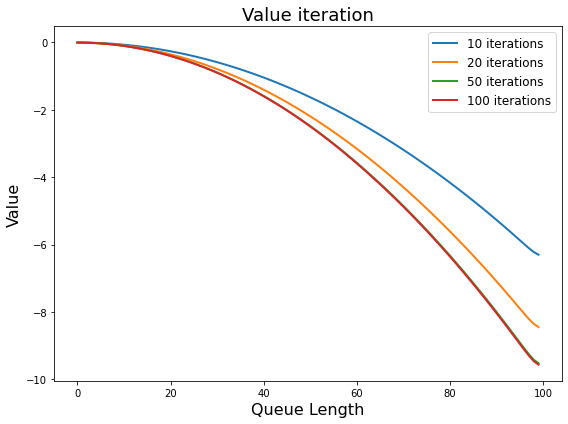

In [18]:
plt.title("Value iteration", fontsize=18)
plt.plot(states, opt_values_VI[0], label="10 iterations", linewidth=2)
plt.plot(states, opt_values_VI[1], label="20 iterations", linewidth=2)
plt.plot(states, opt_values_VI[2], label="50 iterations", linewidth=2)
plt.plot(states, opt_values_VI[3], label="100 iterations", linewidth=2)
plt.legend(loc="upper right", fontsize=12)
plt.xlabel('Queue Length', fontsize=16)
plt.ylabel('Value', fontsize=16)

plt.show()

### Policy Iteration

In [19]:
### policy iteration
# P: X by X by A transition matrix
# r: X-sized reward vector
# gamma: discount factor
# V: initial value-function estimate
# max_iter: number of iterations
def policy_iteration(P,r,gamma,V,max_iter):
    for k in range(max_iter):
        V_next = -np.inf*np.ones(X)
        Q_estimate = np.zeros((X,A))
        pi_greedy = np.zeros((X,A))
        for x in range(X):
            for a in range(A):
                Q_estimate[x,a] = r[x,a] + gamma*P[x,:,a].dot(V)
                if Q_estimate[x,a] > V_next[x]:
                    V_next[x] = Q_estimate[x,a]
                    pi_greedy[x,:] = np.zeros(A)
                    pi_greedy[x,a] = 1
        V = evaluate(P,pi_greedy,r,gamma)
    return V, pi_greedy

In [20]:
iterations = [10, 20, 50, 100]
opt_values_PI = []

for i in iterations:
    opt_value_PI, opt_policy_PI = policy_iteration(P,reward,gamma,np.zeros(X),i)
    opt_values_PI.append(opt_value_PI)

In [21]:
%%time
opt_value_PI_100 = policy_iteration(P,reward,gamma,np.zeros(X),100)

CPU times: user 5.07 s, sys: 760 ms, total: 5.83 s
Wall time: 760 ms


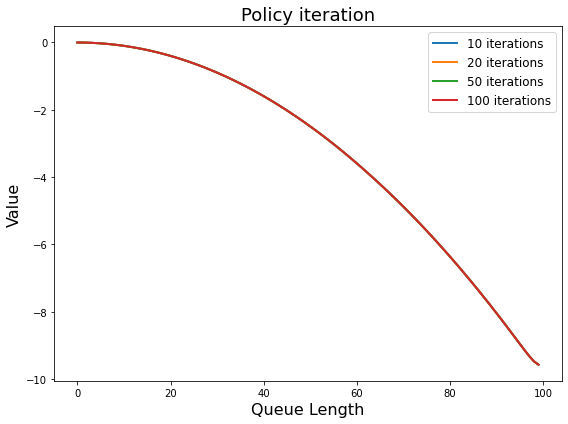

In [22]:
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True

plt.title("Policy iteration", fontsize=18)
plt.plot(states, opt_values_PI[0], label="10 iterations", linewidth=2)
plt.plot(states, opt_values_PI[1], label="20 iterations", linewidth=2)
plt.plot(states, opt_values_PI[2], label="50 iterations", linewidth=2)
plt.plot(states, opt_values_PI[3], label="100 iterations", linewidth=2)
plt.legend(loc="upper right", fontsize=12)
plt.xlabel('Queue Length', fontsize=16)
plt.ylabel('Value', fontsize=16)

plt.show()

### Answer
***Which method converges faster to the optimal value function in terms of the number of iterations? What are the respective runtimes of performing 100 iterations with the two methods? What is your interpretation of these results?***

Policy iteration converges faster to the optimal value function in terms of iterations. It reaches the optimal value function with the minimum number of iterations (10), whilst value iteration requires 50 iterations. Comparing the runtimes we see that the runtime is higher for policy iteration: 735 ms for policy iteration vs 43.8 ms for value iteration when performing 100 iterations. This reflects the higher computational power required by the more complex policy iteration algorithm. Overall, the results show that whilst policy iteration takes longer per iteration, it reaches the optimal value function in fewer iterations. It is thus more reliable in terms of its ability to converge to the optimum when max_iterations are fixed.

### Plot difference in optimal value function when comparing $V^*$ to $V_{lazy}$ and $V_{aggr}$

In [23]:
diff_value_PI_lazy = opt_values_VI[-1] - value_lazy
diff_value_PI_aggr = opt_values_VI[-1] - value_aggr

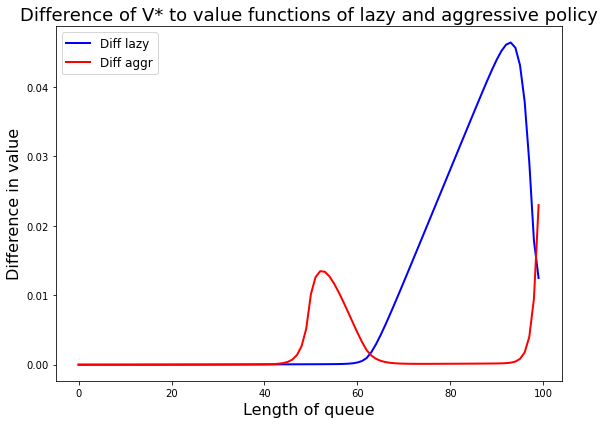

In [24]:
plt.title("Difference of V* to value functions of lazy and aggressive policy", fontsize=18)
plt.plot(states, diff_value_PI_lazy, color="blue", label="Diff lazy", linewidth=2)
plt.plot(states, diff_value_PI_aggr, color="red", label="Diff aggr", linewidth=2)
plt.legend(loc="upper left", fontsize=12)
plt.xlabel('Length of queue', fontsize=16)
plt.ylabel('Difference in value', fontsize=16)

plt.show()

In [25]:
diff_value_PI_aggr[97]

0.004024005622037308

In [26]:
lazy = [str((int(x[0]),int(x[1]))) for x in pi_lazy]
aggr = [str((int(x[0]),int(x[1]))) for x in pi_aggr]
opt = [str((int(x[0]),int(x[1]))) for x in opt_policy_PI]

In [27]:
pd.set_option('display.max_rows', N)
policies = pd.DataFrame({'Lazy policy' : lazy, 'Aggressive policy' : aggr, 'Optimal policy' : opt})
policies

,Lazy policy,Aggressive policy,Optimal policy
0,"(1, 0)","(1, 0)","(1, 0)"
1,"(1, 0)","(1, 0)","(1, 0)"
2,"(1, 0)","(1, 0)","(1, 0)"
3,"(1, 0)","(1, 0)","(1, 0)"
4,"(1, 0)","(1, 0)","(1, 0)"
5,"(1, 0)","(1, 0)","(1, 0)"
6,"(1, 0)","(1, 0)","(1, 0)"
7,"(1, 0)","(1, 0)","(1, 0)"
8,"(1, 0)","(1, 0)","(1, 0)"
9,"(1, 0)","(1, 0)","(1, 0)"


In [28]:
policies['Optimal policy'].value_counts()

(1, 0)    64
(0, 1)    36
Name: Optimal policy, dtype: int64

### Answer
***Can you verify that $V^*$ strictly improves over these value functions? What is the optimal policy and how is it different from the basic ones evaluated in the first problem?***

Plotting the differences $V^*-V_{lazy}$ and $V^*-V_{aggr}$, we can verify that $V^*$ strictly improves over these value functions (the value is either the same or better). Whilst the comparison to the aggressive policy only yields an improvement for states 43 to 63 and post-state 96, $V*$ constitutes an improvement to the lazy policy for all queue lengths bigger than 63.

The optimal policy uses the low service rate $\pi^*(x) = a_{low}$ for $x<64$ and $x=99$ and the high service rate $\pi^*(x) = a_{high}$ for $64 \leq x < 99$. It is thus similar to the aggressive policy in that it uses the low service rate for short queues and the high service rate for long queues. However, the low service rate is applied to comparatively longer queue lengths and also to the terminal state $x=99$ when there are no more positions to be added to the queue.